<a href="https://colab.research.google.com/github/Holzlsauer/california-housing-streamlit/blob/main/model/california_housing_model_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing with Streamlit - Notebook Prep.

Notebook used to develop of the regressor model to predict the housings

## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import files
from joblib import dump
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Auxiliar Functions

In [2]:
def self_corr_lower_triangle(df: pd.DataFrame) -> pd.DataFrame:
    """Return the lower triangle of correlations values from the given dataframe"""
    df_corr = df.corr()
    filter = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)
    return df_corr.where(filter)


In [3]:
def report(scores: np.ndarray) -> None:
    """Take an np array and print the mean, std deviation and the array itself"""
    print(f'Mean score: {scores.mean()}')
    print(f'Std deviation: {scores.std()}')
    print(f'Scores: {scores}')


In [4]:
def download_model(estimator) -> None:
    """Save and download a estimator"""
    dump(estimator, 'estimator.joblib')
    print('Estimator saved.')
    path_to_file = '/content/estimator.joblib'
    files.download(path_to_file)

In [25]:
def download_parameters(estimator) -> None:
    """Save and download the estimator parameters"""
    with open('parameters.json', 'w') as f:
        json.dump(estimator.get_params(), f)
        print('Parameters saved.')
        
    path_to_file = '/content/parameters.json'
    files.download(path_to_file)

## Data Preparation

### Fetch

In [6]:
raw_data = fetch_california_housing(as_frame=True)
data = raw_data['frame']
raw_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [7]:
data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**Features description**:

**MedInc**: median income in block group

**HouseAge**: median house age in block group

**AveRooms**: average number of rooms per household

**AveBedrms**: average number of bedrooms per household

**Population**: block group population

**AveOccup**: average number of household members

**Latitude**: block group latitude

**Longitude**: block group longitude



In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Exploration

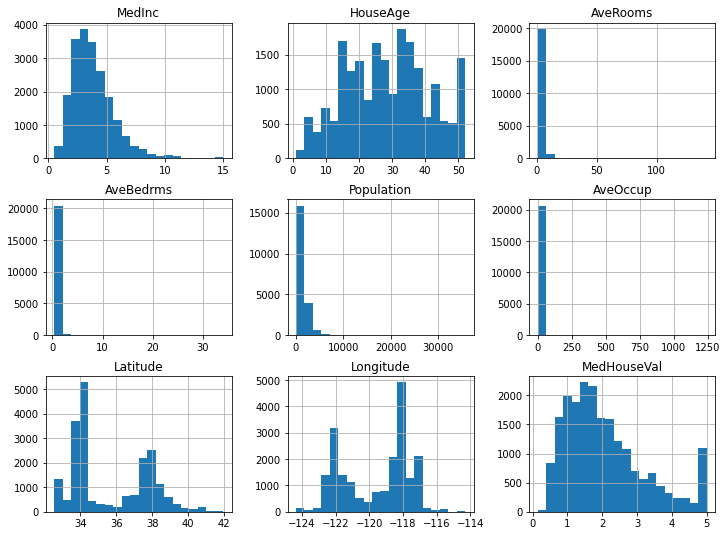

In [9]:
data.hist(bins=20, figsize=(12,9))
plt.show()

In [10]:
filtered_data_corr = self_corr_lower_triangle(data)

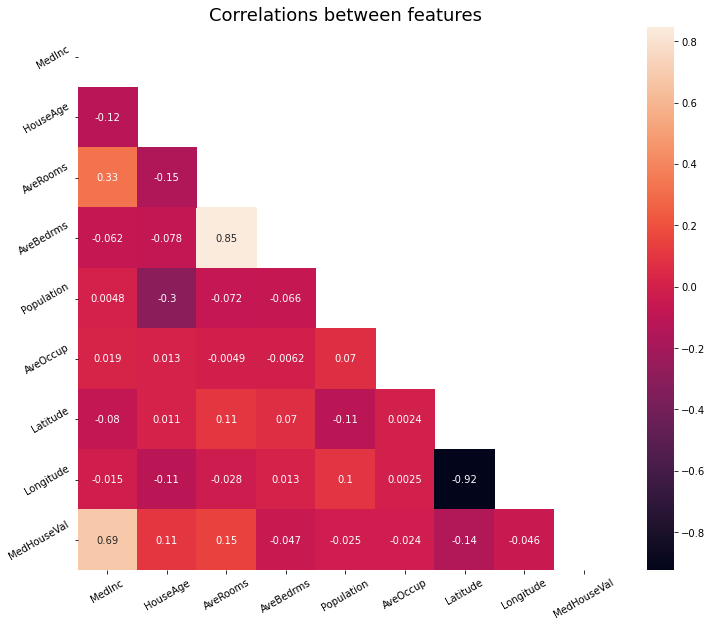

In [11]:
plt.figure(figsize=(12,10))
plt.title('Correlations between features', fontsize=18)
sns.heatmap(filtered_data_corr, annot=True)
plt.yticks(rotation=30)
plt.xticks(rotation=30)
plt.show()

### Preparation

In [12]:
bdrms_col = 3
rooms_col = 2

class BedroomsPerRooms(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.columns_ = None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        bedrooms_per_room = X[:, bdrms_col] / X[:, rooms_col]
        self.columns_ = 'BedrmsRooms'
        return np.c_[X, bedrooms_per_room]


In [13]:
pipeline = Pipeline([
    ('bdrms_rooms', BedroomsPerRooms()),
    ('str_scaller', StandardScaler())
])

In [14]:
target = data[data.columns[-1]].values
data = data[data.columns[:-1]]

data_with_extras = pipeline.fit_transform(data.values)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_with_extras, 
                                                    target, 
                                                    test_size=.25,
                                                    shuffle=True, 
                                                    random_state=0)


## Model

### Training

In [16]:
forest_reg = RandomForestRegressor(random_state=42)
scores = cross_val_score(forest_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
forest_scores = np.sqrt(-scores)

report(forest_scores)

Mean score: 0.5128241813949942
Std deviation: 0.017733787919686907
Scores: [0.5197134  0.51705276 0.51156089 0.53097341 0.51265773 0.53683378
 0.49155749 0.50728282 0.52653072 0.47407882]


### Tunning

In [17]:
params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_features': [3, 6, 9]
}

In [18]:
grid_search = GridSearchCV(forest_reg, param_grid=params, 
                           scoring='neg_mean_squared_error', n_jobs=-1, 
                           return_train_score=True, cv=10)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [3, 6, 9],
                         'n_estimators': [10, 50, 100, 150, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [19]:
grid_results = grid_search.cv_results_

for mean_score, params in zip(grid_results["mean_test_score"], grid_results["params"]):
    print(f'Score: {np.sqrt(-mean_score):.4f} - Params: {params}')

Score: 0.5341 - Params: {'max_features': 3, 'n_estimators': 10}
Score: 0.5015 - Params: {'max_features': 3, 'n_estimators': 50}
Score: 0.4998 - Params: {'max_features': 3, 'n_estimators': 100}
Score: 0.4996 - Params: {'max_features': 3, 'n_estimators': 150}
Score: 0.4996 - Params: {'max_features': 3, 'n_estimators': 200}
Score: 0.5392 - Params: {'max_features': 6, 'n_estimators': 10}
Score: 0.5114 - Params: {'max_features': 6, 'n_estimators': 50}
Score: 0.5080 - Params: {'max_features': 6, 'n_estimators': 100}
Score: 0.5071 - Params: {'max_features': 6, 'n_estimators': 150}
Score: 0.5068 - Params: {'max_features': 6, 'n_estimators': 200}
Score: 0.5414 - Params: {'max_features': 9, 'n_estimators': 10}
Score: 0.5162 - Params: {'max_features': 9, 'n_estimators': 50}
Score: 0.5131 - Params: {'max_features': 9, 'n_estimators': 100}
Score: 0.5130 - Params: {'max_features': 9, 'n_estimators': 150}
Score: 0.5120 - Params: {'max_features': 9, 'n_estimators': 200}


In [20]:
estimator = grid_search.best_estimator_
estimator

RandomForestRegressor(max_features=3, n_estimators=200, random_state=42)

### Evaluation

In [21]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [22]:
# RMSE
print(mean_squared_error(y_test, y_pred, squared=False))

0.5008417950141866


### Final model

In [23]:
estimator.fit(data_with_extras, target)

RandomForestRegressor(max_features=3, n_estimators=200, random_state=42)

## Saving the model

In [24]:
# Uncomment to download the model
# download_model(estimator)

In [26]:
# Uncomment to download the model parameters
download_parameters(estimator)

Parameters saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>